In [1]:
import numpy as np
import pyradiosky
import astropy.units as units
from astropy.units import Quantity
from astropy.coordinates import (
    Latitude,
    Longitude,
    SkyCoord
)
import matplotlib.pyplot as plt
import json
import importlib
importlib.reload(pyradiosky)

<module 'pyradiosky' from '/Users/ruby/opt/anaconda3/lib/python3.8/site-packages/pyradiosky/__init__.py'>

In [2]:
path_to_npz = '/Users/ruby/Astro/rlb_LWA/LWA_skymodels/sourcecatalog.npz'
path_to_bright_sources = '/Users/ruby/Astro/rlb_LWA/LWA_skymodels/bright_sources.json'

In [3]:
cat_data = np.load(path_to_npz)

In [4]:
cat_data.__dict__

{'_files': ['rms_abs.npy',
  'bpa_abs.npy',
  'bmaj_abs.npy',
  'ra_abs.npy',
  'bmin_abs.npy',
  'pkflux_abs.npy',
  'dec_abs.npy'],
 'files': ['rms_abs',
  'bpa_abs',
  'bmaj_abs',
  'ra_abs',
  'bmin_abs',
  'pkflux_abs',
  'dec_abs'],
 'allow_pickle': False,
 'pickle_kwargs': {'encoding': 'ASCII', 'fix_imports': True},
 'zip': <zipfile.ZipFile file=<_io.BufferedReader name='/Users/ruby/Astro/rlb_LWA/LWA_skymodels/sourcecatalog.npz'> mode='r'>,
 'f': <numpy.lib.npyio.BagObj at 0x7fc54966b370>,
 'fid': <_io.BufferedReader name='/Users/ruby/Astro/rlb_LWA/LWA_skymodels/sourcecatalog.npz'>}

In [5]:
def interpolate_flux(
    start_flux, start_freq_mhz, end_freq_mhz,
    spec_index_1=0, spec_index_2=0
):
    end_flux = start_flux*(end_freq_mhz/start_freq_mhz)**(
        spec_index_1 + spec_index_2*np.log10(end_freq_mhz/start_freq_mhz)
    )
    return end_flux

In [6]:
bright_sources_file = open(path_to_bright_sources)
bright_source_data = json.load(bright_sources_file)
bright_sources_file.close()

In [7]:
bright_source_data[0]['components']

[{'name': '1',
  'ra': '19h59m29.990s',
  'dec': '+40d43m57.53s',
  'I': 43170.55527073293,
  'freq': 1000000.0,
  'index': [0.085, -0.178],
  'major-fwhm': 127.86780196141683,
  'minor-fwhm': 22.459884076169928,
  'position-angle': -74.50271323639498},
 {'name': '2',
  'ra': '19h59m24.316s',
  'dec': '+40d44m50.70s',
  'I': 6374.4647292670625,
  'freq': 1000000.0,
  'index': [0.085, -0.178],
  'major-fwhm': 183.42701763410113,
  'minor-fwhm': 141.44188315233822,
  'position-angle': 43.449049376516}]

In [8]:
Nfreqs = 1
freq_hz = 56.*10**6
Ncomponents_bright_sources = sum([len(source['components']) for source in bright_source_data])

ra_bright_sources = Longitude(np.zeros(Ncomponents_bright_sources, dtype=float), units.deg)
dec_bright_sources = Latitude(np.zeros(Ncomponents_bright_sources, dtype=float), units.deg)
stokes_bright_sources = Quantity(np.zeros((4, Nfreqs, Ncomponents_bright_sources), dtype=float), 'Jy')
spec_index_bright_sources = np.zeros(Ncomponents_bright_sources, dtype=float)
name_bright_sources = np.empty(Ncomponents_bright_sources, dtype=str)
extended_group_bright_sources = np.zeros(Ncomponents_bright_sources, dtype=int)

comp_ind = 0
extended_group  = 0
for source in bright_source_data:
    for comp in source['components']:
        comp_coord = SkyCoord(comp['ra'], comp['dec'], frame='icrs')
        ra_bright_sources[comp_ind] = comp_coord.ra
        dec_bright_sources[comp_ind] = comp_coord.dec
        spec_index_1 = comp['index'][0]
        if len(comp['index']) > 1:
            spec_index_2 = comp['index'][1]
        else:
            spec_index_2 = 0.
        flux_I = interpolate_flux(
            comp['I'], comp['freq'], freq_hz, 
            spec_index_1=spec_index_1, spec_index_2=spec_index_2
        )
        stokes_bright_sources[0, 0, comp_ind] = flux_I * units.Jy
        spec_index_bright_sources[comp_ind] = spec_index_1
        name_bright_sources[comp_ind] = '{}_{}'.format(source['name'], comp['name'])
        extended_group_bright_sources[comp_ind] = extended_group

        comp_ind += 1
    extended_group += 1

In [9]:
Ncomponents_npz = np.shape(cat_data['ra_abs'])[0]
ra_npz = Longitude(cat_data['ra_abs'], units.deg)
dec_npz = Latitude(cat_data['dec_abs'], units.deg)
stokes_npz = Quantity(np.zeros((4, Nfreqs, Ncomponents_npz), dtype=float), 'Jy')
stokes_npz[0,0,:] = cat_data['pkflux_abs'] * units.Jy
spectral_index_npz = np.full(Ncomponents_npz, -0.8)
name_npz = [f'LWA_sourcecatalog_{str(source_ind).zfill(4)}' for source_ind in range(Ncomponents_npz)]

In [10]:
ra = np.append(ra_bright_sources, ra_npz)
dec = np.append(dec_bright_sources, dec_npz)
stokes = np.append(stokes_bright_sources, stokes_npz, axis=2)
reference_frequency = Quantity(np.full(Ncomponents_bright_sources+Ncomponents_npz, freq_hz), "hertz")
spectral_index = np.append(spec_index_bright_sources, spectral_index_npz)
name = np.append(name_bright_sources, name_npz)
extended_group = np.append(
    extended_group_bright_sources,
    np.arange(Ncomponents_npz)+np.max(extended_group_bright_sources)+1
)
extended_group = np.array([str(group_id) for group_id in extended_group])

In [11]:
catalog = pyradiosky.SkyModel(
    name=name,
    ra=ra,
    dec=dec,
    stokes=stokes,
    spectral_type="spectral_index",
    reference_frequency=reference_frequency,
    spectral_index=spectral_index,
    extended_model_group = extended_group,
)
catalog.check()

True

In [12]:
named_sources = {
    'Crab': {'ra':83.6331, 'dec':22.0145}, 
    'PicA': {'ra':79.9572, 'dec':-45.7788},
    'HydA': {'ra':139.524, 'dec':-12.0956},
    'CenA': {'ra':201.365, 'dec':-43.0192},
    'HerA': {'ra':252.784, 'dec':4.9925},
    'VirA': {'ra':187.706, 'dec':12.3911},
    'CygA': {'ra':299.868, 'dec':40.7339},
    'CasA': {'ra':350.858, 'dec':58.8},
    '3C161': {'ra':96.7921, 'dec':-5.88472},
    '3C353': {'ra':260.117, 'dec':-0.979722},
    '3C409': {'ra':303.615, 'dec':23.5814},
    '3C444': {'ra':333.607, 'dec':-17.0267},
    'CasA': {'ra':350.866, 'dec':58.8117},
    'ForA': {'ra':50.6738, 'dec':-37.2083},
    'HerA': {'ra':252.793, 'dec':4.99806},
    'NGC0253': {'ra':11.8991, 'dec':-25.2886},
    'PicA': {'ra':79.9541, 'dec':-45.7649},
    'VirA': {'ra':187.706, 'dec':12.3786},
    'PKS0349-27': {'ra':57.8988, 'dec':-27.7431},
    'PKS0442-28': {'ra':71.1571, 'dec':-28.1653},
    'PKS2153-69': {'ra':329.275, 'dec':-69.6900},
    'PKS2331-41': {'ra':353.609, 'dec':-41.4233},
    'PKS2356-61': {'ra':359.768, 'dec':-60.9164},
    'PKSJ0130-2610': {'ra':22.6158, 'dec':-26.1656}
}

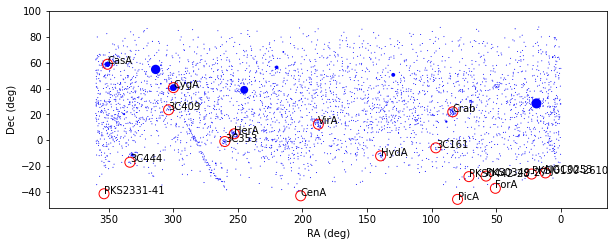

In [13]:
# Plot catalog
ra_range = None
dec_range = None
label_sources = True
label_source_names = None
ra_cut_val = 0.

source_fluxes = catalog.stokes[0, 0, :].value
flux_plot_max = max(source_fluxes)
source_markersizes = []
markersize_range = [1., 100.]
for flux in source_fluxes:
    if flux >= flux_plot_max:
        flux = flux_plot_max
    source_markersizes.append(
        flux/flux_plot_max*(markersize_range[1] - markersize_range[0])
        + markersize_range[0]
    )
    
source_ras = catalog.ra.value
source_decs = catalog.dec.value

if ra_range is None:
    ra_min = min(source_ras)
    ra_max = max(source_ras)
    ra_range = [
        ra_min-(ra_max-ra_min)/10., ra_max+(ra_max-ra_min)/10.
    ]
if dec_range is None:
    dec_min = min(source_decs)
    dec_max = max(source_decs)
    dec_range = [
        dec_min-(dec_max-dec_min)/10., dec_max+(dec_max-dec_min)/10.
    ]

plt.figure(figsize=(10,10))
ax = plt.gca()
plt.scatter(
    source_ras, source_decs, s=source_markersizes, facecolors='blue',
    edgecolors='none'
    )

if label_sources:
    if label_source_names is None:
        label_source_names = list(named_sources.keys())
    named_source_ras = [named_sources[name]['ra'] for name in label_source_names]
    named_source_decs = [named_sources[name]['dec'] for name in label_source_names]
    plt.scatter(
        named_source_ras, named_source_decs, marker='o',
        s=markersize_range[1], facecolors='none', edgecolors='red',
        linewidth=1
    )
    for i, name in enumerate(label_source_names):
        plt.annotate(
            name, (named_source_ras[i], named_source_decs[i]),
            fontsize=10.
        )

plt.xlim(ra_range[1], ra_range[0])
plt.ylim(dec_range[0], dec_range[1])
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
ax.set_aspect('equal', adjustable='box')
ax.set_facecolor('white')
plt.savefig('/Users/ruby/Desktop/source_plot.png', format='png', dpi=600)
plt.show()

In [14]:
from astropy.io import fits


In [15]:
catalogfile = open('/Users/ruby/Astro/FullVLSSCatalog.text')
catalogdata = catalogfile.readlines()
catalogfile.close()

In [93]:
start_line = 17
cat_RA_h = []
cat_RA_m = []
cat_RA_s = []
cat_Dec_d = []
cat_Dec_m = []
cat_Dec_s = []
flux = []

line = start_line
while line < len(catalogdata)-1:
#while line < 54:
    if catalogdata[line][0:6].strip() == 'NVSS':  # Remove page breaks
        line +=3
    line_data = catalogdata[line]
    cat_RA_h.append(line_data[0:2])
    cat_RA_m.append(line_data[2:5])
    cat_RA_s.append(line_data[5:11])
    cat_Dec_d.append(line_data[11:15])
    cat_Dec_m.append(line_data[15:18])
    cat_Dec_s.append(line_data[18:23])
    flux.append(line_data[29:36])
    line += 2

In [94]:
cat_RA_h = np.array([int(val) for val in cat_RA_h])
cat_RA_m = np.array([int(val) for val in cat_RA_m])
cat_RA_s = np.array([float(val) for val in cat_RA_s])
cat_Dec_d_int = np.array([int(val) for val in cat_Dec_d])
cat_Dec_m = np.array([int(val) for val in cat_Dec_m])
cat_Dec_s = np.array([float(val) for val in cat_Dec_s])
cat_RA = cat_RA_h + cat_RA_m/60. + cat_RA_s/(60.**2.)
cat_RA = cat_RA*15.  # Convert to degrees
cat_Dec = np.abs(cat_Dec_d_int) + cat_Dec_m/60. + cat_Dec_s/(60.**2.)
for dec_ind in range(len(cat_Dec)):
    if cat_Dec_d[dec_ind][1:2] == "-":
        cat_Dec[dec_ind] *= -1
flux = np.array([float(val) for val in flux])

92696


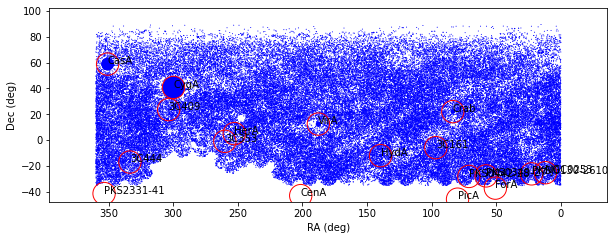

In [96]:
# Plot catalog
ra_range = None
dec_range = None
label_sources = True
label_source_names = None
ra_cut_val = 0.

source_fluxes = list(flux)
flux_plot_max = max(source_fluxes)
source_markersizes = []
markersize_range = [1., 500.]
for use_flux in source_fluxes:
    if use_flux >= flux_plot_max:
        use_flux = flux_plot_max
    source_markersizes.append(
        use_flux/flux_plot_max*(markersize_range[1] - markersize_range[0])
        + markersize_range[0]
    )
print(len(source_markersizes))
    
source_ras = cat_RA
source_decs = cat_Dec

if ra_range is None:
    ra_min = min(source_ras)
    ra_max = max(source_ras)
    ra_range = [
        ra_min-(ra_max-ra_min)/10., ra_max+(ra_max-ra_min)/10.
    ]
if dec_range is None:
    dec_min = min(source_decs)
    dec_max = max(source_decs)
    dec_range = [
        dec_min-(dec_max-dec_min)/10., dec_max+(dec_max-dec_min)/10.
    ]

plt.figure(figsize=(10,10))
ax = plt.gca()
plt.scatter(
    source_ras, source_decs, s=source_markersizes, facecolors='blue',
    edgecolors='none'
)

if label_sources:
    if label_source_names is None:
        label_source_names = list(named_sources.keys())
    named_source_ras = [named_sources[name]['ra'] for name in label_source_names]
    named_source_decs = [named_sources[name]['dec'] for name in label_source_names]
    plt.scatter(
        named_source_ras, named_source_decs, marker='o',
        s=markersize_range[1], facecolors='none', edgecolors='red',
        linewidth=1
    )
    for i, name in enumerate(label_source_names):
        plt.annotate(
            name, (named_source_ras[i], named_source_decs[i]),
            fontsize=10.
        )

plt.xlim(ra_range[1], ra_range[0])
plt.ylim(dec_range[0], dec_range[1])
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
ax.set_aspect('equal', adjustable='box')
ax.set_facecolor('white')
plt.show()

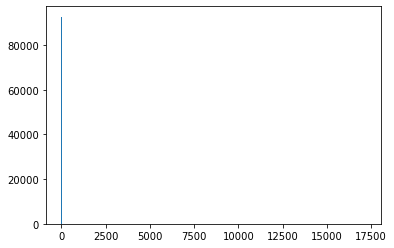

In [82]:
plt.hist(flux, bins=300)
plt.show()

In [109]:
np.shape(np.where(flux > 10))

(1, 1442)

In [99]:
print(nsources)

92696


In [100]:
nsources = len(cat_RA)
nfreqs = 1
cat_stokes = Quantity(np.zeros((4, nfreqs, nsources), dtype=float), 'Jy')
cat_stokes[0,0,:] = flux * units.Jy
cat_spectral_index = np.full(nsources, -0.8)
cat_name = [f'VLSSr_sourcecatalog_{str(source_ind+1).zfill(6)}' for source_ind in range(nsources)]

In [102]:
vlssr_catalog = pyradiosky.SkyModel(
    name=cat_name,
    ra=Longitude(cat_RA, units.deg),
    dec=Latitude(cat_Dec, units.deg),
    stokes=cat_stokes,
    spectral_type="spectral_index",
    reference_frequency=Quantity(np.full(nsources, 73.8*1e6), "hertz"),
    spectral_index=cat_spectral_index,
)
vlssr_catalog.check()

True